# Signal Selection

## Objectives:

   * Compute the energy resolution of the $\beta\beta0\nu$, $^{214}\mathrm{Bi}$, $^{208}\mathrm{Tl}$ peaks, using simulated data

## Physics

The energy resolution of the $Q_{\beta\beta}$ peak is one of the key parameters of the analysis.

The resolution in fact degfines the width of the RoI and therefore the possible number of background events.

## Energy resolution

In [52]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Importing modules

In [53]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.constants as constants

import warnings
warnings.filterwarnings('ignore')

In [54]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
rootpath = os.getcwd()[:-15]
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/


In [55]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
pltext.style()

### Main parameters

In the next cell we define the main parameters of the selection

In [56]:
from collpars import collaboration
print('Collaboration             : {:s}'.format(coll))

Collaboration             : new_beta


## Access the data

In the next cell we read the data (in a *h5* format), and access the simulated data of the backgrounds and the signal. 

We output the number of events in the simulated samples

In [57]:
# set the path to the data directory and filenames
dirpath = rootpath+'/data/'
filename = 'fanal_' + coll + '.h5'
print('Data path and filename : ', dirpath + filename)

# access the simulated data (DataFrames) for the different samples (Bi, Tl, bb) located in the data file
mcbi = pd.read_hdf(dirpath + filename, key = 'mc/bi214')
mctl = pd.read_hdf(dirpath + filename, key = 'mc/tl208')
mcbb = pd.read_hdf(dirpath + filename, key = 'mc/bb0nu')

# set the names of the samples
# set the names of the samples
mc_samples         = [mcbi, mctl, mcbb] # list of the mc DFs
sample_names       = ['Bi', 'Tl', 'bb']
sample_names_latex = [ r'$^{214}$Bi', r'$^{208}$Tl', r'$\beta\beta0\nu$',] # str names of the mc samples

for i, mc in enumerate(mc_samples):
    print('MC Sample {:s}, number of simulated events = {:d}'.format(sample_names[i], len(mc)))

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2//data/fanal_new_beta.h5
MC Sample Bi, number of simulated events = 60184
MC Sample Tl, number of simulated events = 687297
MC Sample bb, number of simulated events = 47636


## Estimate the energy resolution 

The energy resolution is a crucial parameters in this analysis.

We fit the energy distribution of the $^{214}\mathrm{Bi}$, $^{208}\mathrm{Tl}$ and the $\beta\beta0\nu$ peaks to a gaussian on top of a pedestal modeled as an stragith line

Give the relative energy resolution as the percentage of $\sigma/E$ or FWHM/E (Full Width Have Maximum).

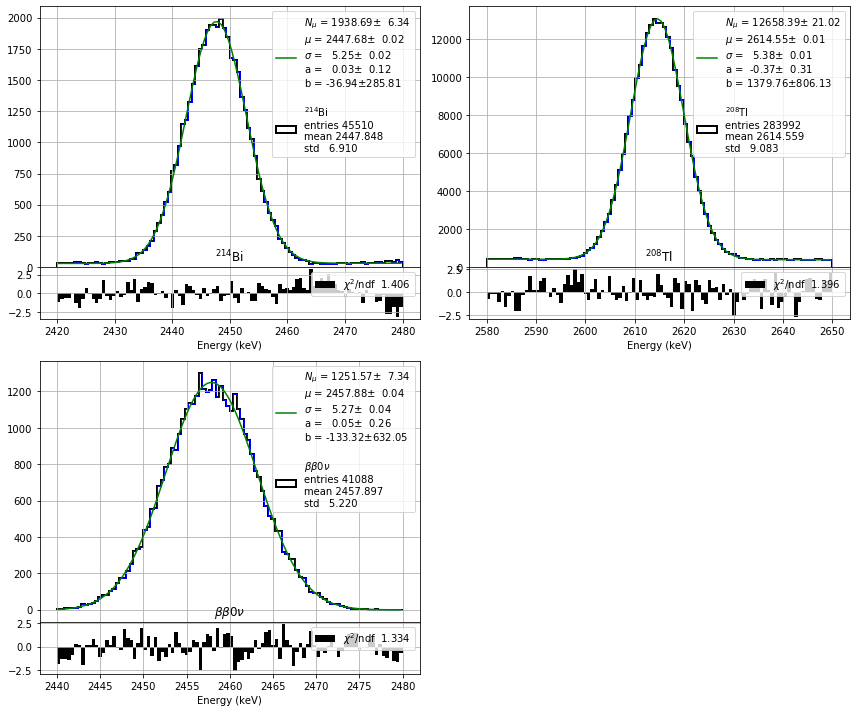

In [58]:
eranges = ((2420., 2480.), (2580, 2650), (2440, 2480))
fitfuns = ('gausline', 'gausline', 'gausline')
guesses =((10e3, 2445., 20., 0., 300.), (50e3, 2615., 20., 0., 1.), (50e3, 2458., 20., 0., 0.))

subplot = pltext.canvas(4)

resolutions = [] 
for i, mc in enumerate(mc_samples):
    sample = sample_names_latex[i]
    subplot(i + 1)
    pltext.hist   (1e3 * mc.E, 100, range = eranges[i], label = sample, lw = 2);
    pars, _, _, _ = pltext.hfitres(1e3 * mc.E, 100, range = eranges[i], fun = fitfuns[i], guess = guesses[i],)
    resolutions.append((pars[2], pars[1])) # stores mu and sigma from the fit!
    plt.xlabel('Energy (keV)'); plt.title(sample)
plt.tight_layout();

In [59]:
for i, pars in enumerate(resolutions):
    sigma, fwhm = pars[0], 100 * 2.35 * pars[0]/pars[1]
    print('Energy resolution {:s}: sigma {:6.2f} KeV, {:6.2f} % FWHM'.format(sample_names[i], sigma, fwhm))

Energy resolution Bi: sigma   5.25 KeV,   0.50 % FWHM
Energy resolution Tl: sigma   5.38 KeV,   0.48 % FWHM
Energy resolution bb: sigma   5.27 KeV,   0.50 % FWHM


### Write out

We write the relevant python variables into a file *collpars.py*, which contains the relevant parameters of the analysis and which will be used in the following notebooks.

WE write out into the parameter file:

  * The selection cuts
  * The efficiencies of the selection for each sample

In [60]:
write = True
if (write):
    of = open('collpars.py', 'a')
    for i, sample in enumerate(sample_names):
        sigma = resolutions[i][0]
        of.write('sigma_'+sample+'        = {:1.2e} # keV'.format(sigma)+'\n')
    of.close()